In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Лабораторная работа №8, часть 2

In [3]:
from itertools import islice

import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.io import loadmat
from scipy.stats import multivariate_normal

from common import f1_score, threshold_gen

## Загрузка данных

In [4]:
DATA = loadmat("ex8data2.mat")

X_TRAIN = DATA["X"]
EXAMPLE_COUNT = X_TRAIN.shape[0]
DIMENSION_COUNT = X_TRAIN.shape[1]

X_VAL = DATA["Xval"]
Y_VAL = DATA["yval"]
Y_VAL_FLATTENED = np.ravel(Y_VAL)

### Гистограммы случайных величин

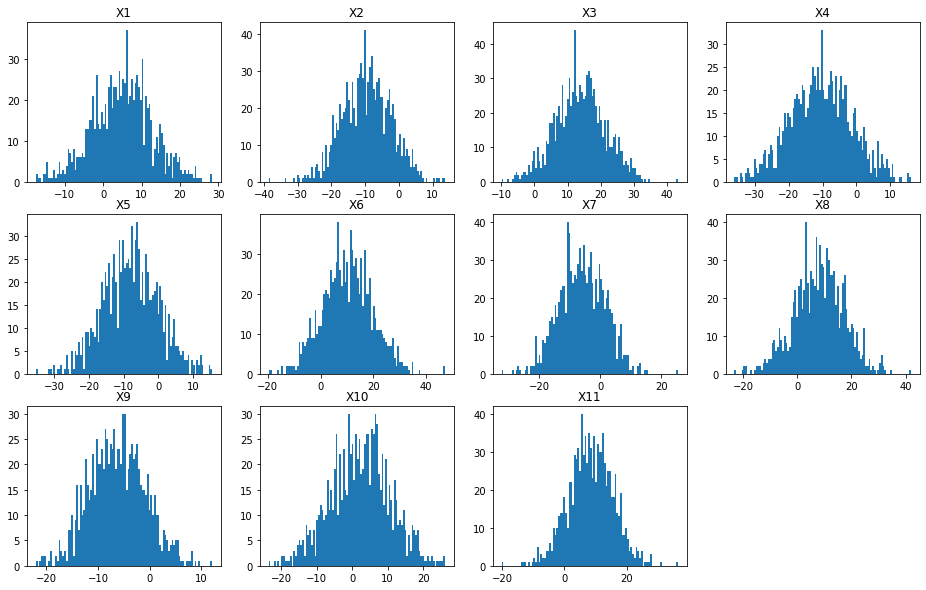

In [5]:
GRAPH_COLS = 4
GRAPH_ROWS = -(-DIMENSION_COUNT // GRAPH_COLS)  # ceil division

hist_fig, hist_axes = plt.subplots(ncols=GRAPH_COLS, nrows=GRAPH_ROWS, figsize=(16, 10))
hist_axes = hist_axes.flatten()

empty_axes_count = GRAPH_ROWS * GRAPH_COLS - DIMENSION_COUNT
for ax in hist_axes[-empty_axes_count:]:
    ax.axis("off")

for index in range(DIMENSION_COUNT):
    ax = hist_axes[index]
    ax.hist(X_TRAIN[:, index], bins=100)
    ax.set_title(f"X{index + 1}")

plt.show()

### Параметры распределения случайных величин

In [6]:
means = np.mean(X_TRAIN, axis=0)
variances = np.var(X_TRAIN, axis=0)
scales = np.sqrt(variances)

print(f"Means = {means}")
print(f"Variances = {variances}")
print(f"Scales = {scales}")

Means = [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252]
Variances = [60.97489373 53.20572186 58.51546272 84.20403725 65.26859177 89.57487757
 55.63349911 87.16233783 29.62926829 70.7852052  50.50356719]
Scales = [7.80864225 7.29422524 7.64954003 9.17627578 8.07889793 9.46440054
 7.4587867  9.33607722 5.44327735 8.41339439 7.10658618]


#### Ковариационная матрица
\begin{equation}
\Sigma = \frac{1}{m - 1} \sum_{i=1}^{m}
\left(
X_i - \mu
\right)^T
\left(
X_i - \mu
\right)
\end{equation}

In [7]:
deviations = X_TRAIN - means
covariance_matrix = (deviations.T @ deviations) / (EXAMPLE_COUNT - 1)
DataFrame(covariance_matrix)

0          1          2          3          4          5  \
0   61.035930   1.314583   0.693511   0.130364   4.681187  -0.532519   
1    1.314583  53.258981  -2.226883  -4.610783   1.734714   3.082635   
2    0.693511  -2.226883  58.574037   2.626325   3.311684  -3.391139   
3    0.130364  -4.610783   2.626325  84.288326   1.907196   1.428353   
4    4.681187   1.734714   3.311684   1.907196  65.333926   1.184338   
5   -0.532519   3.082635  -3.391139   1.428353   1.184338  89.664542   
6   -3.382125   1.384834   2.849118   3.766864   5.414941   2.258749   
7    4.946758   7.520487   2.177699   2.570716  -2.526312   1.326746   
8   -1.155293   4.198534   7.235789  -4.182472   0.747582  -0.120596   
9    3.916385  -4.830286   5.894876   1.914341   4.016777  -3.433440   
10  -2.906491   7.722360  -2.849422  -1.232358  -0.517578   1.275621   

            6          7          8          9         10  
0   -3.382125   4.946758  -1.155293   3.916385  -2.906491  
1    1.384834   7.520487   4.198534  -4.830286   7.722360  
2    2.849118   2.177699   7.235789   5.894876  -2.849422  
3    3.766864   2.570716  -4.182472   1.914341  -1.232358  
4    5.414941  -2.526312   0.747582   4.016777  -0.517578  
5    2.258749   1.326746  -0.120596  -3.433440   1.275621  
6   55.689188  -1.626520  -1.568366  -1.464856  -5.358843  
7   -1.626520  87.249587   3.664037  -1.265500   2.366665  
8   -1.568366   3.664037  29.658927  -0.466670   2.345768  
9   -1.464856  -1.265500  -0.466670  70.856061  -0.338301  
10  -5.358843   2.366665   2.345768  -0.338301  50.554121

### Многомерное нормальное распределение
\begin{equation}
p(x; \mu, \Sigma) = \frac{1}{(2 \pi)^{\frac{n}{2}}\det \Sigma ^{\frac{1}{2}}}
\exp
\left(
-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)
\right)
\end{equation}

In [8]:
configured_multivariate_normal = multivariate_normal(mean=means, cov=covariance_matrix)

### Получение вероятностей для примеров

In [9]:
probabilities_val = configured_multivariate_normal.pdf(X_VAL)

### Подбор значения порога для обнаружения аномалий

In [10]:
OPTIMAL_THRESHOLD = None
best_score = 0
for threshold in islice(threshold_gen(1e-18), 8):
    anomaly_hypotheses = probabilities_val < threshold
    score = f1_score(anomaly_hypotheses, Y_VAL_FLATTENED)
    if score > best_score:
        best_score = score
        OPTIMAL_THRESHOLD = threshold
    print(f"threshold = {threshold:6.2}\t score = {score:.2%}")

print("=" * 69)
print(f"Optimal threshold = {OPTIMAL_THRESHOLD:.2}")

threshold =  1e-18	 score = 61.54%
threshold =  5e-19	 score = 69.57%
threshold =  1e-19	 score = 66.67%
threshold =  5e-20	 score = 66.67%
threshold =  1e-20	 score = 75.00%
threshold =  5e-21	 score = 75.00%
threshold =  1e-21	 score = 66.67%
threshold =  5e-22	 score = 57.14%
Optimal threshold = 1e-20


### Поиск аномалий в обучающей выборке

In [11]:
probabilities_train = configured_multivariate_normal.pdf(X_TRAIN)
anomalies_train = X_TRAIN[probabilities_train < OPTIMAL_THRESHOLD]
anomalies_count = anomalies_train.shape[0]
print(f"{anomalies_count} anomal{'y' if anomalies_count == 1 else 'ies'} found.")

8 anomalies found.
